Lab 5 
Andrik Solano Jimenez Ronald Arce Matamoros

Librerías

In [542]:
import os
import random
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg  
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')


Entendimiento de los datos

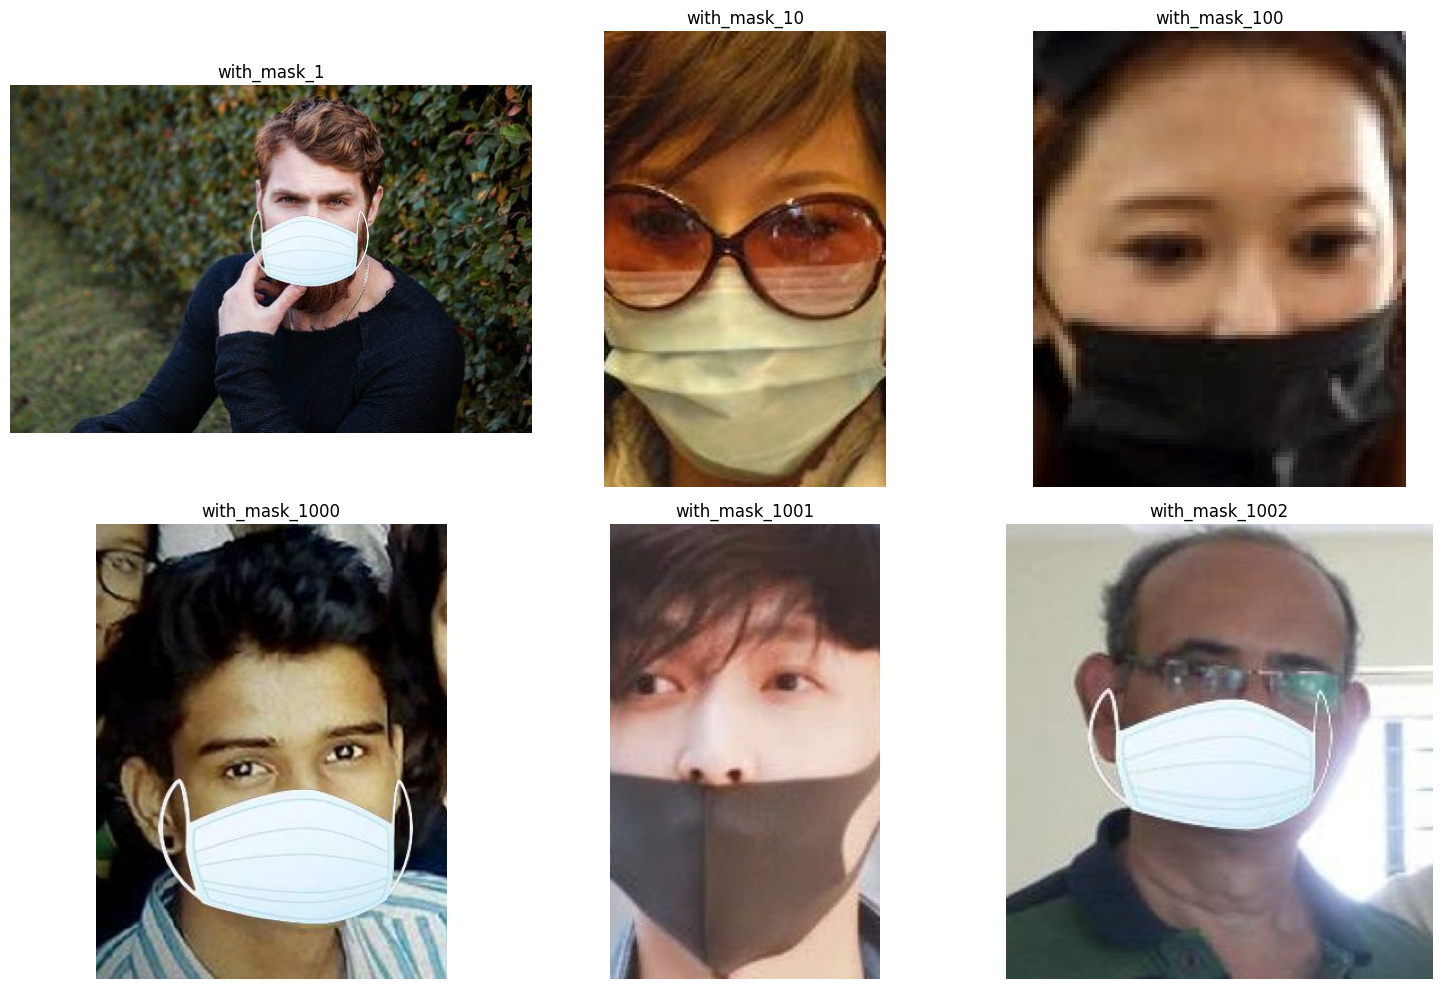

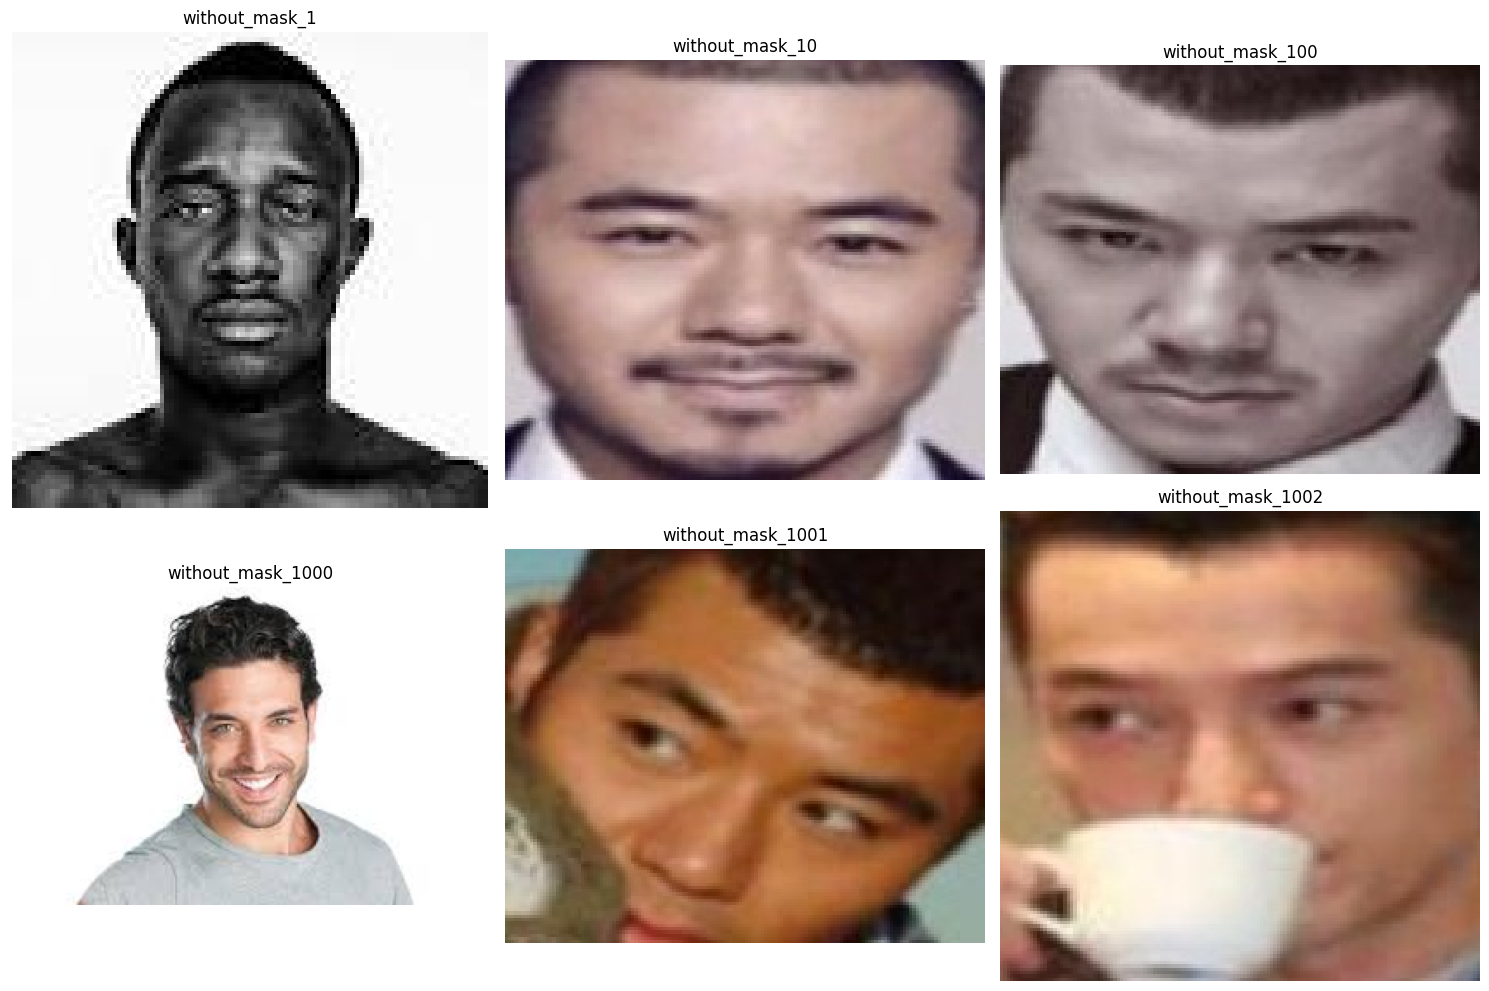

In [543]:
def display_images_with_labels(path, num_images=6):
    # Get a list of all image file names in the directory
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    # Display the images with their labels
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(min(num_images, len(image_files))):
        # Get the image file name and its label
        image_file = image_files[i]
        label = image_file.split('.')[0]

        # Load and display the image
        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# Example usage:
path = "./data/with_mask"
display_images_with_labels(path)

path = "./data/without_mask"
display_images_with_labels(path)

Procesamiento de los datos

In [544]:
batch_size = 10
img_height = 100
img_width = 100

In [545]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [546]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [547]:
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


In [548]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [549]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Modelo Deep Learning

In [550]:
# Compilar el modelo
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
Conv2D(32, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5), 
  tf.keras.layers.Dense(num_classes)
])

In [551]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

# Compile the model with a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)
model.compile(
  optimizer=optimizer,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
callbacks=[early_stopping]
)

Epoch 1/10
605/605 [==============================] - 10s 15ms/step - loss: 0.3548 - accuracy: 0.8504 - val_loss: 0.2043 - val_accuracy: 0.9205
Epoch 2/10
605/605 [==============================] - 8s 14ms/step - loss: 0.2318 - accuracy: 0.9100 - val_loss: 0.1779 - val_accuracy: 0.9371
Epoch 3/10
605/605 [==============================] - 8s 14ms/step - loss: 0.1987 - accuracy: 0.9259 - val_loss: 0.1503 - val_accuracy: 0.9391
Epoch 4/10
605/605 [==============================] - 8s 14ms/step - loss: 0.1690 - accuracy: 0.9373 - val_loss: 0.1617 - val_accuracy: 0.9457
Epoch 5/10
605/605 [==============================] - 8s 14ms/step - loss: 0.1494 - accuracy: 0.9479 - val_loss: 0.1291 - val_accuracy: 0.9490
Epoch 6/10
605/605 [==============================] - 9s 14ms/step - loss: 0.1421 - accuracy: 0.9480 - val_loss: 0.1501 - val_accuracy: 0.9437
Epoch 7/10
605/605 [==============================] - 8s 14ms/step - loss: 0.1030 - accuracy: 0.9643 - val_loss: 0.1466 - val_accuracy: 0.951

Evaluacion

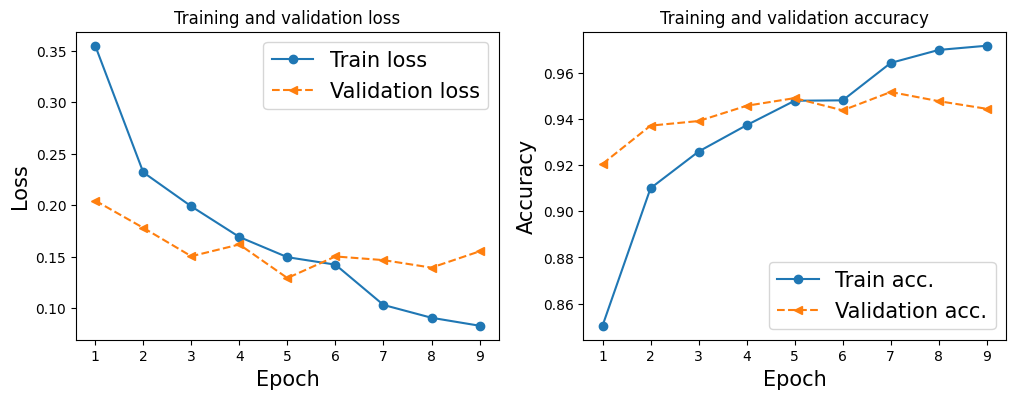

In [552]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_title("Training and validation loss")
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.set_title("Training and validation accuracy")
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_18.png', dpi=300)
plt.show()

In [553]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(val_ds)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

151/151 [==============================] - 2s 10ms/step - loss: 0.1466 - accuracy: 0.9517
Test Loss: 0.1465606838464737
Test Accuracy: 0.9516556262969971


Resultados